In [1]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import datetime
import warnings
warnings.filterwarnings('ignore')
from pandas.tseries.offsets import BusinessDay
from pandas.tseries.offsets import MonthEnd
import numpy as np
import zqdatac
import matplotlib.pyplot as plt

In [2]:
reps = [d.strftime('%Y%m%d') for d in pd.date_range(start='20100331',end='20221231',freq='3M')]
reps_semi = [d.strftime('%Y%m%d') for d in pd.date_range(start='20100630',end='20221231',freq='6M')]

In [3]:
calendar = zqdatac.MarketCalendar().dates

### 权益型基金

筛选投资A股的股票&混合型公募基金，\
剔除（被动指数类基金、指数增强类基金、量化基金），剔除FOF，剔除QDII，若分级只保留A份额，\
剔除股票仓位不足50%

In [4]:
def newly_listed(df_descri,trade_dates,sl,day=365):
    df_descri = df_descri.sort_values(by='OPDATE')
    df_descri = df_descri.set_index(['F_INFO_WINDCODE'])
    df_descri = df_descri[~df_descri.index.duplicated(keep='last')]['F_INFO_SETUPDATE'].reset_index()
    df_descri = df_descri[df_descri.F_INFO_WINDCODE.isin(sl)]
    df_descri['VALID_DATE'] = ((pd.to_datetime(df_descri.F_INFO_SETUPDATE.astype(str))+pd.Timedelta(days=day)).dt.strftime('%Y%m%d')).astype(int)
    df_valid = df_descri[['F_INFO_WINDCODE', 'VALID_DATE']].set_index(['F_INFO_WINDCODE']).T
    df_dates = pd.DataFrame(index=trade_dates, data=df_valid.values.tolist() * len(trade_dates),
                                columns=df_valid.columns)
    df_valid = df_dates.sub(trade_dates,axis=0)<=0
    df_valid.index.name = None
    df_valid.columns.name = None
    return df_valid

In [5]:
def still_alive(df_descri,trade_dates,sl):
    df_descri['F_INFO_MATURITYDATE'] = df_descri.F_INFO_MATURITYDATE.fillna(datetime.datetime.now().strftime('%Y%m%d'))
    df_descri = df_descri.sort_values(by='OPDATE')
    df_descri = df_descri.set_index(['F_INFO_WINDCODE'])
    df_descri = df_descri[~df_descri.index.duplicated(keep='last')]['F_INFO_MATURITYDATE'].reset_index()
    df_descri = df_descri[df_descri.F_INFO_WINDCODE.isin(sl)]
    df_descri['VALID_DATE'] = (df_descri.F_INFO_MATURITYDATE).astype(int)
    df_valid = df_descri[['F_INFO_WINDCODE', 'VALID_DATE']].set_index(['F_INFO_WINDCODE']).T
    df_dates = pd.DataFrame(index=trade_dates, data=df_valid.values.tolist() * len(trade_dates),
                                columns=df_valid.columns)
    df_valid = df_dates.sub(trade_dates,axis=0)>=0
    df_valid.index.name = None
    df_valid.columns.name = None
    return df_valid

In [6]:
fund_descri = pq.read_table('data/ChinaMutualFundDescription.parquet.gz').to_pandas()
    ### A股权益类（股票&混合型基金），剔除（被动指数类基金、指数增强类基金、量化基金），剔除FOF，剔除QDII，若分级只保留A份额
    ### QDII中重仓A股的：110011.OF,002891.OF,005698.OF,006308.OF,001984.OF,005534.OF,003243.OF,012920.OF
fund_code_list = fund_descri[(fund_descri.F_INFO_FIRSTINVESTTYPE.isin(['股票型', '混合型'])) &
                             (fund_descri.IS_INDEXFUND == 0) &
                             (fund_descri.CRNY_CODE == 'CNY') &
                             (fund_descri.F_INFO_NAME.str.find('FOF') == -1) & (fund_descri.F_INFO_FULLNAME.str.find('FOF') == -1) &
                             (fund_descri.F_INFO_NAME.str.find('QDII') == -1) & (fund_descri.F_INFO_FULLNAME.str.find('QDII') == -1) &
                             (fund_descri.F_INFO_NAME.str.find('量化') == -1) & (fund_descri.F_INFO_FULLNAME.str.find('量化') == -1) &
                             (fund_descri.F_INFO_ISINITIAL == 1) &
                             (fund_descri.F_INVESTMENT_AREA.isin(
                                 [None]))].F_INFO_WINDCODE.unique().tolist()
### 基金在报告期时成立时间大于半年
df_setup = newly_listed(fund_descri.dropna(subset=['F_INFO_SETUPDATE']), trade_dates=[int(d) for d in reps],
                        sl=fund_code_list, day=365 * 0.5)
### 基金在报告期时未到期
df_mature = still_alive(fund_descri, trade_dates=[int(d) for d in reps],
                        sl=df_setup.any(0)[df_setup.any(0)].index.tolist())
df_alive = (df_setup[df_setup.any(0)[df_setup.any(0)].index.tolist()]) & (df_mature)
df_alive = df_alive[df_alive.any(0)[df_alive.any(0)].index.tolist()]
df_alive.index = df_alive.index.astype(str)
del fund_descri

In [7]:
### 基金股票仓位占比在50%以上
fundasset = pq.read_table('data/ChinaMutualFundAssetPortfolio.parquet.gz').to_pandas()
fundasset = fundasset.set_index(['F_PRT_ENDDATE', 'S_INFO_WINDCODE'])
df_asset = fundasset.sort_values(by=['F_ANN_DATE', 'OPDATE'], ascending=[True, False])

df_stk = df_asset[~df_asset.index.duplicated(keep='first')]['F_PRT_STOCKTONAV']
df_stk = df_stk.unstack().reindex(reps)
# df_stk = df_stk.rolling(4, min_periods=2).mean()
df_stk = df_stk.reindex(df_alive.columns, axis='columns')[df_alive]
df_stk = df_stk >= 50

del fundasset

In [8]:
### 筛选结果求交集
df_avail = df_alive & df_stk
df_avail = df_avail[df_avail.any(0)[df_avail.any(0)].index.tolist()]

### 权益基金主管经理

将基金与基金经理关联，\
同一报告期同一基金名下挂了多个基金经理的，将基金与主管基金经理（资历最长）关联

In [9]:
df_manager = pq.read_table('data/ChinaMutualFundManager.parquet.gz').to_pandas()
df_manager = df_manager[df_manager.F_INFO_WINDCODE.isin(fund_code_list)]
df_manager = df_manager.merge(df_manager[~df_manager.F_INFO_MANAGER_STARTDATE.isna()].groupby(['F_INFO_FUNDMANAGER_ID']).F_INFO_MANAGER_STARTDATE.min().astype(int).to_frame('TENURE'),
                 how='left',left_on='F_INFO_FUNDMANAGER_ID',right_index=True)
### 整理每个权益基金名下各基金经理的任期
manger_records = []
df_manager['F_INFO_MANAGER_LEAVEDATE'] = df_manager.F_INFO_MANAGER_LEAVEDATE.fillna('20230201')
for i,row in df_manager.iterrows():
    if row.F_INFO_MANAGER_STARTDATE is None:
        continue
    start = int(row.F_INFO_MANAGER_STARTDATE)
    end = int(row.F_INFO_MANAGER_LEAVEDATE)
    fund = row.F_INFO_WINDCODE               
    df = pd.DataFrame(index=calendar.loc[start:end].index,columns=[fund],data=[row.F_INFO_FUNDMANAGER_ID]*len(calendar.loc[start:end]))
    manger_records.append(df)
df_main_manager = pd.concat(manger_records,axis=1)
df_main_manager = df_main_manager.stack().to_frame('FUNDMANAGER_ID')
df_main_manager.index.names = ['TRADE_DT','FUNDCODE']
df_main_manager = df_main_manager.reset_index()
### 基金名下同一时期有多个基金经理挂名的，按各个基金经理最早管理权益型基金的任职日期计算资历
df_main_manager = df_main_manager.merge(df_manager[~df_manager.F_INFO_MANAGER_STARTDATE.isna()].groupby(['F_INFO_FUNDMANAGER_ID']).F_INFO_MANAGER_STARTDATE.min().astype(int).to_frame('TENURE'),
                     how='left',left_on=['FUNDMANAGER_ID'],right_index=True)
### 基金名下同一时期有多个基金经理挂名的，以资历最长的基金经理作为主管基金经理
df_main_manager = df_main_manager.sort_values(by=['FUNDCODE','TRADE_DT','TENURE'])
df_main_manager = df_main_manager.drop_duplicates(subset=['FUNDCODE','TRADE_DT'],keep='first')
mat_main_manager = df_main_manager.set_index(['TRADE_DT','FUNDCODE'])['FUNDMANAGER_ID'].unstack()

In [10]:
# mat_main_manager.to_pickle('main_manager.pkl')

In [11]:
mat_main_manager = pd.read_pickle('main_manager.pkl')

### 行业主题型基金经理

按行业持仓倾向高于同期均值20%，或位于同期行业持仓倾向的top10的标准筛选出行业主题型基金经理

In [12]:
### 筛选中报和年报的全持仓数据
holding = pq.read_table('data/ChinaMutualFundStockPortfolio.parquet.gz').to_pandas()
holding = holding[holding.F_PRT_ENDDATE.str[-4:].isin(['0630','1231'])]

In [13]:
### 取每个报告期筛选出的基金的全持仓数据
holding = holding[
    (holding.S_INFO_WINDCODE.isin(df_avail.columns.tolist())) & (holding.F_PRT_ENDDATE.isin(reps_semi))]
holding = holding.set_index(['S_INFO_WINDCODE', 'F_PRT_ENDDATE', 'S_INFO_STOCKWINDCODE'])
holding = holding.sort_values(by=['F_PRT_ENDDATE', 'OPDATE'], ascending=[True, False])
holding = holding[~holding.index.duplicated(keep='first')]
holding = holding.reset_index()

In [14]:
mat_ind = zqdatac.industryCitics(level=1)
mat_ind = mat_ind.fillna(0).reindex(zqdatac.MarketCalendar().dates.loc[20100101:20221231].index).fillna(
    method='ffill').pipe(lambda x: x.mask(x == 0))
mat_ind.index = mat_ind.index.astype(str)

In [15]:
ind_mapping = {1: 'CI005001.WI', 2: 'CI005002.WI', 3: 'CI005003.WI', 4: 'CI005004.WI', 5: 'CI005005.WI',
               6: 'CI005006.WI', 7: 'CI005007.WI', 8: 'CI005008.WI', 9: 'CI005009.WI', 10: 'CI005010.WI',
               11: 'CI005011.WI', 12: 'CI005012.WI', 13: 'CI005013.WI', 14: 'CI005014.WI', 15: 'CI005015.WI',
               16: 'CI005016.WI', 17: 'CI005017.WI',18: 'CI005018.WI', 19: 'CI005019.WI', 20: 'CI005020.WI',
               21: 'CI005021.WI', 22: 'CI005022.WI', 23: 'CI005023.WI', 24: 'CI005030.WI', 25: 'CI005024.WI',
               26: 'CI005025.WI', 27: 'CI005026.WI', 28: 'CI005027.WI', 29: 'CI005028.WI', 30: 'CI005029.WI'}

In [16]:
### 计算全市场所有基金不同时期在不同行业的持仓比例
df_ind = mat_ind.reindex(reps_semi).stack().to_frame('IndustryCitics')
df_ind.index.names = ['F_PRT_ENDDATE', 'S_INFO_STOCKWINDCODE']
mat_main_manager.index = mat_main_manager.index.astype(str)
mat_main_manager = mat_main_manager.stack().to_frame('F_MANAGER')
mat_main_manager.index.names = ['F_PRT_ENDDATE','S_INFO_WINDCODE']
mat_main_manager = mat_main_manager.reset_index()
manager_holding = holding.merge(mat_main_manager,how='left',on=['S_INFO_WINDCODE','F_PRT_ENDDATE'])
manager_holding_ind = manager_holding.merge(df_ind.reset_index(), how='left', on=['F_PRT_ENDDATE', 'S_INFO_STOCKWINDCODE'])
manager_holding_ind = manager_holding_ind[['F_MANAGER','S_INFO_WINDCODE','F_PRT_ENDDATE','S_INFO_STOCKWINDCODE','F_PRT_STKVALUETONAV','IndustryCitics']]

In [17]:
### 以主管基金经理名下基金在某行业持股比例和的最大值作为基金经理的行业持仓倾向
holding_ind = manager_holding_ind.groupby(['F_PRT_ENDDATE','S_INFO_WINDCODE','IndustryCitics']).F_PRT_STKVALUETONAV.sum().reset_index()
manager_holding_ind_weight = holding_ind.merge(mat_main_manager,how='left',on=['F_PRT_ENDDATE','S_INFO_WINDCODE'])
manager_holding_ind_weight = manager_holding_ind_weight.groupby(['F_MANAGER','F_PRT_ENDDATE','IndustryCitics']).F_PRT_STKVALUETONAV.max()
manager_holding_ind_weight = ((manager_holding_ind_weight.to_frame('Ind_Weight')).reset_index()).merge(manager_holding_ind_weight.swaplevel().unstack().unstack().mean().to_frame('Ind_Weight_avg').reset_index(),
                                                            how='left',on=['F_PRT_ENDDATE','IndustryCitics'])
manager_holding_ind_weight['Ind_Weight_rank'] = manager_holding_ind_weight.groupby(['F_PRT_ENDDATE','IndustryCitics']).Ind_Weight.rank(method='min',ascending=False)

In [18]:
### 筛选出行业持仓倾向高于同期均值20%，或位于同期行业持仓倾向的top10的基金经理
ind_manager = manager_holding_ind_weight[(manager_holding_ind_weight.Ind_Weight-manager_holding_ind_weight.Ind_Weight_avg>=20)\
                                         | (manager_holding_ind_weight.Ind_Weight_rank<=10)]

In [19]:
ind_manager = ind_manager.rename(columns={'F_MANAGER':'F_INFO_FUNDMANAGER_ID'})
manager_names = pq.read_table('data/ChinaMutualFundManager.parquet.gz').to_pandas().set_index(['F_INFO_FUNDMANAGER_ID'])['F_INFO_FUNDMANAGER'].dropna().reset_index().drop_duplicates()
ind_manager = ind_manager.merge(manager_names,how='left',on=['F_INFO_FUNDMANAGER_ID'])

In [20]:
ind_manager.to_pickle('ind_manager.pkl')

In [21]:
ind_manager = pd.read_pickle('ind_manager.pkl')

### 季报重仓（前十大）

回看中报/年报发布前的上一季度，由上一季度（0331/0930）至中部/年报（0630/1231）区间，上一季报中重仓股相对行业指数的超额表现

In [22]:
stocks = pq.read_table('data/ChinaMutualFundStockPortfolio.parquet.gz').to_pandas()
stocks = stocks[stocks.F_PRT_ENDDATE.str[-4:].isin(['0331','0930','0630','1231'])]
stocks['ANN_DEADLINE'] = pd.to_datetime(stocks['F_PRT_ENDDATE']) + BusinessDay(20)
stocks = stocks[(stocks['ANN_DEADLINE'] - pd.to_datetime(stocks['ANN_DATE'])).dt.days >= 0]
stocks = stocks[(stocks.S_INFO_WINDCODE.isin(fund_code_list))&(stocks.F_PRT_ENDDATE.isin(reps))]
stocks['STK_HLD_RANK'] = stocks.groupby(['S_INFO_WINDCODE', 'F_PRT_ENDDATE']).F_PRT_STKVALUETONAV.apply(
        lambda x: x.rank(method='min', ascending=False))
top10_stocks = stocks[stocks.STK_HLD_RANK <= 10]
top10_stocks = top10_stocks[(top10_stocks.S_INFO_STOCKWINDCODE.str[0].isin(['0', '3', '6'])) & (top10_stocks.S_INFO_STOCKWINDCODE.str[-3:].isin(['.SZ', '.SH']))]
df_ind = mat_ind.reindex(reps).stack().to_frame('IndustryCitics')
df_ind.index.names = ['F_PRT_ENDDATE', 'S_INFO_STOCKWINDCODE']
top10_stocks = top10_stocks[['S_INFO_WINDCODE','F_PRT_ENDDATE','S_INFO_STOCKWINDCODE','F_PRT_STKVALUETONAV','STOCK_PER','FLOAT_SHR_PER']].merge(df_ind,how='left',on=['F_PRT_ENDDATE','S_INFO_STOCKWINDCODE'])

In [23]:
### 计算上一期季报重仓股自上一期季报日期（非公告日期）至当期季报日期（非公告日期）区间内重仓股涨幅
top10_stocks['F_PRT_ENDDATE'] = top10_stocks.F_PRT_ENDDATE.apply(lambda x:dict(zip(reps,reps[1:]+['20230331']))[x])
stk_list = top10_stocks.S_INFO_STOCKWINDCODE.unique().tolist()
mat_close = pd.read_pickle('mat_close.pkl')
dts = [str(d) for d in [20091231]+[int(d) for d in reps]]
dt_delay = lambda x: pd.Timestamp(x) + MonthEnd(0)
dts = [int(dt_delay(d).strftime('%Y%m%d')) for d in dts]
mat_close = mat_close.fillna(method='ffill').reindex(index=zqdatac.MarketCalendar().dates.loc[dts].TRADE_DT.tolist())
mat_close.index = ['20091231'] + reps
df_ret = mat_close.reindex(columns=stk_list).pct_change(fill_method=None).iloc[1:]
df_ret = df_ret.stack().to_frame('Ret')
df_ret.index.names = ['F_PRT_ENDDATE','S_INFO_STOCKWINDCODE']
top10_stocks = (top10_stocks).merge(df_ret.reset_index(),how='left',on=['F_PRT_ENDDATE','S_INFO_STOCKWINDCODE'])


In [24]:
### 计算上一期季报重仓股自上一期季报日期（非公告日期）至当期季报日期（非公告日期）区间内中信行业指数涨幅
# df_index = pq.read_table('data/AIndexWindIndustriesEOD.parquet.gz').to_pandas()
# df_index = df_index.sort_values(by=['S_INFO_WINDCODE','TRADE_DT','OPDATE','OPMODE']).drop_duplicates(subset=['S_INFO_WINDCODE','TRADE_DT'],keep='last')
# ind_close = df_index.set_index(['TRADE_DT','S_INFO_WINDCODE'])['S_DQ_CLOSE'].unstack().fillna(method='ffill')
# ind_close.index = ind_close.index.astype(int)
# ind_close.to_pickle('ind_close.pkl')
ind_close = pd.read_pickle('ind_close.pkl')
ind_close = ind_close.reindex(index=zqdatac.MarketCalendar().dates.loc[dts].TRADE_DT.tolist())
ind_close.index = ['20091231']+reps
ind_close.index.names = ['F_PRT_ENDDATE']
ind_ret = ind_close.pct_change(fill_method=None).iloc[1:]
ind_ret = ind_ret.stack().to_frame('Ind_Ret').reset_index()
ind_ret['S_INFO_WINDCODE'] = ind_ret.S_INFO_WINDCODE.apply(lambda x:dict(zip(ind_mapping.values(),ind_mapping.keys()))[x])
ind_ret = ind_ret.rename(columns={'S_INFO_WINDCODE':'IndustryCitics'})

In [25]:
### 计算上一期季报重仓股自上一期季报日期（非公告日期）至当期季报日期（非公告日期）区间内基金经理的行业重仓的超额表现
top10_stocks = top10_stocks.merge(ind_ret,how='left',on=['F_PRT_ENDDATE','IndustryCitics'])
top10_stocks['F_PRT_ENDDATE'] = top10_stocks.F_PRT_ENDDATE.astype(int)
mat_main_manager = pd.read_pickle('main_manager.pkl')
top10_stocks = top10_stocks.merge(mat_main_manager.reindex([int(rep) for rep in reps]).stack().to_frame('F_INFO_FUNDMANAGER_ID'),how='left',left_on=['F_PRT_ENDDATE','S_INFO_WINDCODE'],right_on=['TRADE_DT','FUNDCODE'])
top10_stocks['Alpha'] = top10_stocks.Ret - top10_stocks.Ind_Ret

### 不考虑仓位（等权持有）的重仓业绩

In [26]:
### 以各期基金经理名下基金的行业重仓股超额均值，作为基金经理的行业重仓超额表现
stocks_eval = top10_stocks.drop_duplicates(subset=['F_PRT_ENDDATE','S_INFO_STOCKWINDCODE','F_INFO_FUNDMANAGER_ID'],keep='last')
stocks_eval['F_PRT_ENDDATE'] = stocks_eval.F_PRT_ENDDATE.astype(str)
stocks_eval = stocks_eval.groupby(['F_PRT_ENDDATE','F_INFO_FUNDMANAGER_ID','IndustryCitics']).Alpha.mean()
stocks_eval = stocks_eval.reset_index()

In [27]:
def portf_stages(df_portf,mat_close,ind_close):
    # 中报/年报公布后的最近一个季报发布：0630->0731;1231->0131
    dts = [str(d) for d in [20091231]+[int(d) for d in reps_semi]]
    dt_delay1 = lambda x: pd.Timestamp(x) + MonthEnd(0) if x.endswith('1231') else pd.Timestamp(x) + MonthEnd(0)
    dt_delay2 = lambda x: pd.Timestamp(x) + MonthEnd(1) if x.endswith('1231') else pd.Timestamp(x) + MonthEnd(1)
    dts1 = [int(dt_delay1(d).strftime('%Y%m%d')) for d in dts]
    dts2 = [int(dt_delay2(d).strftime('%Y%m%d')) for d in dts]
    fut_ret1 = mat_close.fillna(method='ffill').reindex(index=zqdatac.MarketCalendar().dates.loc[dts1+dts2].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    fut_ret1.index = ['20091231']+[d for d in reps_semi]
    fut_ret1.index.names = ['F_PRT_ENDDATE']
    fut_ret1 = fut_ret1.stack().to_frame('FUT_RET1')
    ind_ret1 = ind_close.reindex(index=zqdatac.MarketCalendar().dates.loc[dts1+dts2].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    ind_ret1.index = ['20091231']+[d for d in reps_semi]
    ind_ret1.index.names = ['F_PRT_ENDDATE']
    ind_ret1 = ind_ret1.stack().to_frame('IND_FUT_RET1')
    # 最近一个季报发布到中报/年报发布：0731->0831;0131->0331
    dt_delay3 = lambda x: pd.Timestamp(x) + MonthEnd(3) if x.endswith('1231') else pd.Timestamp(x) + MonthEnd(2)
    dts3 = [int(dt_delay3(d).strftime('%Y%m%d')) for d in dts]
    fut_ret2 = mat_close.fillna(method='ffill').reindex(index=zqdatac.MarketCalendar().dates.loc[dts2+dts3].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    fut_ret2.index = ['20091231']+[d for d in reps_semi]
    fut_ret2.index.names = ['F_PRT_ENDDATE']
    fut_ret2 = fut_ret2.stack().to_frame('FUT_RET2')
    ind_ret2 = ind_close.reindex(index=zqdatac.MarketCalendar().dates.loc[dts2+dts3].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    ind_ret2.index = ['20091231']+[d for d in reps_semi]
    ind_ret2.index.names = ['F_PRT_ENDDATE']
    ind_ret2 = ind_ret2.stack().to_frame('IND_FUT_RET2')
    # 中报/年报发布到下一个季报发布：0831->1031;0331->0430
    dt_delay4 = lambda x: pd.Timestamp(x) + MonthEnd(4) if x.endswith('1231') else pd.Timestamp(x) + MonthEnd(4)
    dts4 = [int(dt_delay4(d).strftime('%Y%m%d')) for d in dts]
    fut_ret3 = mat_close.fillna(method='ffill').reindex(index=zqdatac.MarketCalendar().dates.loc[dts3+dts4].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    fut_ret3.index = ['20091231']+[d for d in reps_semi]
    fut_ret3.index.names = ['F_PRT_ENDDATE']
    fut_ret3 = fut_ret3.stack().to_frame('FUT_RET3')
    ind_ret3 = ind_close.reindex(index=zqdatac.MarketCalendar().dates.loc[dts3+dts4].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    ind_ret3.index = ['20091231']+[d for d in reps_semi]
    ind_ret3.index.names = ['F_PRT_ENDDATE']
    ind_ret3 = ind_ret3.stack().to_frame('IND_FUT_RET3')
    # 下一个季报发布到下下一个季报发布：1031->0131;0430->0731
    dt_delay5 = lambda x: pd.Timestamp(x) + MonthEnd(7) if x.endswith('1231') else pd.Timestamp(x) + MonthEnd(7)
    dts5 = [int(dt_delay5(d).strftime('%Y%m%d')) for d in dts]
    fut_ret4 = mat_close.fillna(method='ffill').reindex(index=zqdatac.MarketCalendar().dates.loc[dts4+dts5].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    fut_ret4.index = ['20091231']+[d for d in reps_semi]
    fut_ret4.index.names = ['F_PRT_ENDDATE']
    fut_ret4 = fut_ret4.stack().to_frame('FUT_RET4')
    ind_ret4 = ind_close.reindex(index=zqdatac.MarketCalendar().dates.loc[dts4+dts5].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    ind_ret4.index = ['20091231']+[d for d in reps_semi]
    ind_ret4.index.names = ['F_PRT_ENDDATE']
    ind_ret4 = ind_ret4.stack().to_frame('IND_FUT_RET4')
    # 下下一个季报发布到下一个年报/中报发布：0131->0331;0731->0831
    dt_delay6 = lambda x: pd.Timestamp(x) + MonthEnd(8) if x.endswith('1231') else pd.Timestamp(x) + MonthEnd(9)
    dts6 = [int(dt_delay6(d).strftime('%Y%m%d')) for d in dts]
    fut_ret5 = mat_close.fillna(method='ffill').reindex(index=zqdatac.MarketCalendar().dates.loc[dts5+dts6].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    fut_ret5.index = ['20091231']+[d for d in reps_semi]
    fut_ret5.index.names = ['F_PRT_ENDDATE']
    fut_ret5 = fut_ret5.stack().to_frame('FUT_RET5')
    ind_ret5 = ind_close.reindex(index=zqdatac.MarketCalendar().dates.loc[dts5+dts6].TRADE_DT.tolist()).sort_index().pct_change(fill_method=None).shift(-1)[::2]
    ind_ret5.index = ['20091231']+[d for d in reps_semi]
    ind_ret5.index.names = ['F_PRT_ENDDATE']
    ind_ret5 = ind_ret5.stack().to_frame('IND_FUT_RET5')
    
    fut_ret = pd.concat([fut_ret1,fut_ret2,fut_ret3,fut_ret4,fut_ret5],axis=1)
    ind_ret = pd.concat([ind_ret1,ind_ret2,ind_ret3,ind_ret4,ind_ret5],axis=1)
    fut_ret = fut_ret.reset_index()
    ind_ret = ind_ret.reset_index()
    ind_ret['S_INFO_WINDCODE'] = ind_ret.S_INFO_WINDCODE.apply(lambda x:dict(zip(ind_mapping.values(),ind_mapping.keys()))[x])
    ind_ret = ind_ret.rename(columns={'S_INFO_WINDCODE':'IndustryCitics'})
    
    df_portf = df_portf.merge(fut_ret,how='left',on=['F_PRT_ENDDATE','STOCK_CODE'])
    df_portf = df_portf.merge(ind_ret,how='left',on=['F_PRT_ENDDATE','IndustryCitics'])
    
    df_portf['ALPHA1'] = df_portf.FUT_RET1 - df_portf.IND_FUT_RET1
    df_portf['ALPHA2'] = df_portf.FUT_RET2 - df_portf.IND_FUT_RET2
    df_portf['ALPHA3'] = df_portf.FUT_RET3 - df_portf.IND_FUT_RET3
    df_portf['ALPHA4'] = df_portf.FUT_RET4 - df_portf.IND_FUT_RET4
    df_portf['ALPHA5'] = df_portf.FUT_RET5 - df_portf.IND_FUT_RET5
    
    return df_portf

### 年报/半年报基金经理的全持仓

In [28]:
portf_list = []
for ind,sub in ind_manager.groupby('IndustryCitics'):
    if len(sub) < 10:
        continue
    print(ind,len(sub))
    sub = sub.merge(stocks_eval[stocks_eval.IndustryCitics==ind],how='left',on=['F_INFO_FUNDMANAGER_ID','F_PRT_ENDDATE','IndustryCitics'])
    hld = manager_holding_ind[manager_holding_ind.IndustryCitics==ind]
    hld = hld.groupby(['F_PRT_ENDDATE','F_MANAGER'])['S_INFO_STOCKWINDCODE'].apply(list).to_frame()
    portf = sub.merge(hld,how='left',left_on=['F_PRT_ENDDATE','F_INFO_FUNDMANAGER_ID'],right_index=True)
    portf = portf.set_index(['F_INFO_FUNDMANAGER_ID','F_PRT_ENDDATE','IndustryCitics'])['S_INFO_STOCKWINDCODE'].explode()
    portf_list.append(portf)

1.0 260
2.0 267
3.0 329
4.0 260
5.0 260
6.0 284
7.0 260
8.0 260
9.0 260
10.0 265
11.0 604
12.0 405
13.0 268
14.0 260
15.0 260
16.0 260
17.0 261
18.0 1166
19.0 906
20.0 287
21.0 368
22.0 294
23.0 279
24.0 63
25.0 260
26.0 748
27.0 260
28.0 469
29.0 264
30.0 261


In [29]:
portf = pd.concat(portf_list,axis=0)
portf = portf.reset_index(level='F_INFO_FUNDMANAGER_ID',drop=True)
portf = portf.to_frame('STOCK_CODE')
portf['num'] = 1
portf = portf.set_index(['STOCK_CODE'],append=True)
portf['total'] = portf.groupby(['F_PRT_ENDDATE','IndustryCitics','STOCK_CODE']).num.sum()

In [30]:
df_portf = portf.reset_index()
df_portf = df_portf.drop_duplicates(subset=['F_PRT_ENDDATE','IndustryCitics','STOCK_CODE'],keep='last')

##### 中报公布的全持仓行业等权组合，从中报未公布到下一年报公布之间的5个区间，相对行业指数的超额表现

In [31]:
### 计算全持仓从年报/半年报日期（非公告日期）至下一期半年报/年报的公告日期之间，各个阶段的行业持股超额
mat_close = pd.read_pickle('mat_close.pkl')
ind_close = pd.read_pickle('ind_close.pkl')
df_portf1 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('0630')],mat_close,ind_close)
format_dict = {'ALPHA1': '{:.2%}','ALPHA2': '{:.2%}','ALPHA3': '{:.2%}','ALPHA4': '{:.2%}','ALPHA5': '{:.2%}'}
#### 中报为起点
#### ALPHA1（不可得超额）: 0630->0731
#### ALPHA2（不可得超额）: 0731->0831
#### ALPHA3（可得超额）: 0831->1031
#### ALPHA4（可得超额）: 1031->0131
#### ALPHA5（可得超额）: 0131->0331
alpha_stats1 = pd.concat([(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
alpha_stats1.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,0.80%,1.32%,-0.41%,-1.34%,0.92%
2.0,1.05%,0.37%,0.13%,-0.88%,1.26%
3.0,0.99%,-0.02%,-0.12%,0.05%,0.07%
4.0,0.51%,1.15%,-0.11%,-0.62%,0.95%
5.0,1.88%,1.68%,-0.57%,1.83%,-0.31%
6.0,0.41%,0.82%,0.45%,0.98%,-0.26%
7.0,-0.53%,1.58%,-0.67%,-2.94%,2.11%
8.0,0.43%,0.76%,-0.22%,2.05%,0.39%
9.0,0.19%,0.46%,-1.02%,1.56%,0.20%


##### 年报的全持仓行业等权组合，从年报未公布到下一中报公布之间的5个区间，相对行业指数的超额表现

In [32]:
#### 年报为起点
#### ALPHA1（不可得超额）: 1231->0131
#### ALPHA2（不可得超额）: 0131->0331
#### ALPHA3（可得超额）: 0331->0430
#### ALPHA4（可得超额）: 0430->0731
#### ALPHA5（可得超额）: 0731->0831
df_portf2 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('1231')],mat_close,ind_close)
alpha_stats2 = pd.concat([(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
alpha_stats2.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,-0.41%,1.36%,-0.83%,3.48%,1.00%
2.0,0.93%,0.91%,0.13%,1.29%,0.89%
3.0,0.07%,-0.07%,-0.17%,1.80%,0.12%
4.0,-0.37%,0.24%,-0.83%,0.53%,0.47%
5.0,1.22%,-1.18%,-1.19%,1.08%,1.14%
6.0,0.20%,0.03%,0.04%,1.91%,-0.10%
7.0,0.91%,1.71%,-1.79%,2.58%,0.41%
8.0,1.68%,0.37%,0.75%,1.52%,0.35%
9.0,0.93%,0.33%,-0.53%,1.21%,0.62%


In [33]:
### 准备个股自当期年报/半年报至下一个半年报/年报区间内的未来收益率
dts = [str(d) for d in [20091231]+[int(d) for d in reps_semi]]
dt_delay = lambda x: pd.Timestamp(x) + MonthEnd(3) if x.endswith('1231') else pd.Timestamp(x) + MonthEnd(2)
dts = [int(dt_delay(d).strftime('%Y%m%d')) for d in dts]
fut_ret = mat_close.fillna(method='ffill').reindex(index=zqdatac.MarketCalendar().dates.loc[dts].TRADE_DT.tolist()).pct_change(fill_method=None).shift(-1)
fut_ret.index = ['20091231']+[d for d in reps_semi]
fut_ret.index.names = ['F_PRT_ENDDATE']
fut_ret = fut_ret.stack().to_frame('FUT_RET').reset_index()
### 准备中信行业指数自当期年报/半年报至下一个半年报/年报区间内的未来收益率
ind_close = pd.read_pickle('ind_close.pkl')
ind_ret = ind_close.reindex(index=zqdatac.MarketCalendar().dates.loc[dts].TRADE_DT.tolist()).pct_change(fill_method=None).shift(-1)
ind_ret.index = ['20091231']+[d for d in reps_semi]
ind_ret.index.names = ['F_PRT_ENDDATE']
ind_ret = ind_ret.stack().to_frame('IND_FUT_RET').reset_index()
ind_ret['S_INFO_WINDCODE'] = ind_ret.S_INFO_WINDCODE.apply(lambda x:dict(zip(ind_mapping.values(),ind_mapping.keys()))[x])
ind_ret = ind_ret.rename(columns={'S_INFO_WINDCODE':'IndustryCitics'})

##### 逐行业统计

<AxesSubplot:xlabel='F_PRT_ENDDATE'>

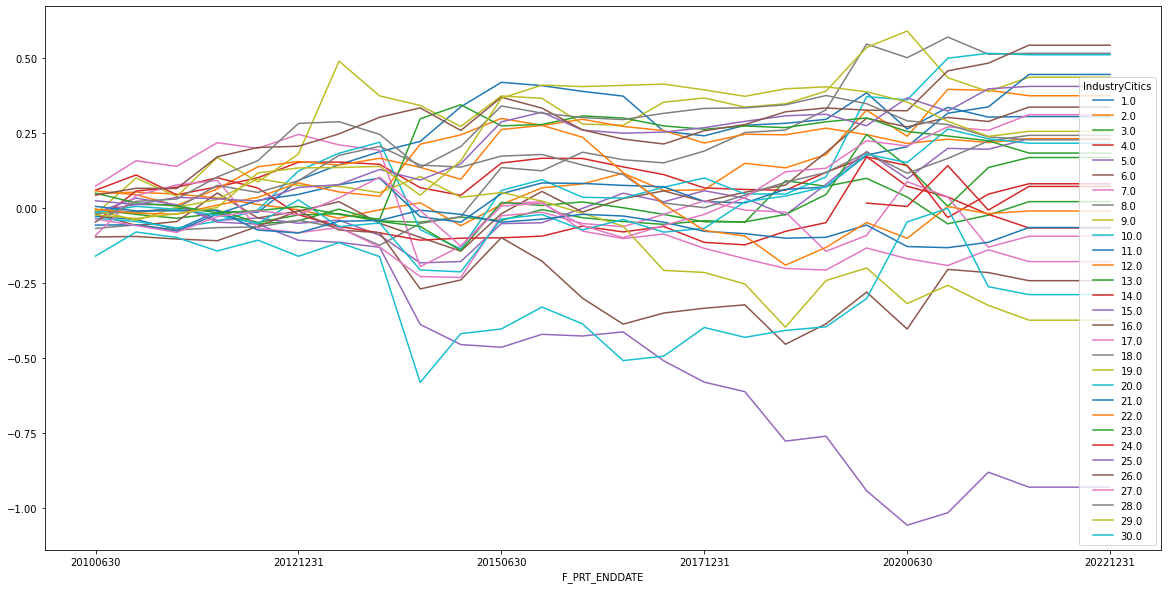

In [34]:
#### ALPHA := ALPHA3 + ALPHA4 + ALPHA5 
df_portf = df_portf.merge(fut_ret,how='left',on=['F_PRT_ENDDATE','STOCK_CODE'])
df_portf = df_portf.merge(ind_ret,how='left',on=['F_PRT_ENDDATE','IndustryCitics'])
df_portf['ALPHA'] = df_portf.FUT_RET - df_portf.IND_FUT_RET
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().cumsum().fillna(method='ffill').plot(figsize=(20,10))

In [35]:
(2*df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().mean()).sort_values()

IndustryCitics
15.0   -0.077597
19.0   -0.031195
30.0   -0.024090
16.0   -0.020217
7.0    -0.014912
17.0   -0.007861
4.0    -0.005558
21.0   -0.005439
22.0   -0.000852
3.0     0.001751
14.0    0.006713
13.0    0.014010
23.0    0.015251
20.0    0.017986
28.0    0.018938
5.0     0.019205
12.0    0.019261
18.0    0.020166
29.0    0.021286
1.0     0.025402
27.0    0.025919
6.0     0.028022
24.0    0.028678
2.0     0.031171
25.0    0.033772
9.0     0.036315
11.0    0.037090
10.0    0.042558
8.0     0.042968
26.0    0.045225
dtype: float64

##### 逐行业逐年统计

In [36]:
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().T.dropna(how='all',axis=1).style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, align='zero')

F_PRT_ENDDATE,20100630,20101231,20110630,20111231,20120630,20121231,20130630,20131231,20140630,20141231,20150630,20151231,20160630,20161231,20170630,20171231,20180630,20181231,20190630,20191231,20200630,20201231,20210630,20211231
IndustryCitics,,,,,,,,,,,,,,,,,,,,,,,,
1.0,-0.027236,-0.011826,-0.032671,0.059289,-0.002164,0.106662,0.052095,0.043338,0.034339,0.115322,0.081729,-0.011168,-0.019145,-0.015648,-0.117337,-0.015149,0.035122,0.006610,0.013295,0.088325,-0.120779,0.072302,-0.032531,0.002053
2.0,0.047326,0.005335,-0.006594,-0.012977,-0.021344,-0.017888,-0.027984,0.027847,0.023335,-0.076446,0.070574,0.055753,0.013130,0.035712,-0.057447,0.001825,0.088627,-0.015112,0.043953,0.148256,-0.087047,0.156419,-0.002864,-0.018336
3.0,-0.004917,-0.016731,-0.012696,0.016288,-0.035366,0.010669,0.038661,-0.039352,-0.004307,0.017176,-0.011092,0.036099,-0.027071,-0.012640,-0.009573,0.012278,-0.005088,0.138273,-0.018406,0.026508,-0.062463,-0.089303,0.029102,0.044958
4.0,0.059104,0.050928,-0.066306,0.026906,0.030052,0.051620,0.000610,-0.007433,-0.077901,-0.025492,0.107668,0.015791,-0.000719,-0.028043,-0.025618,-0.044486,-0.005104,-0.002873,0.059997,0.052104,-0.098794,-0.035465,-0.057827,-0.045415
5.0,-0.010752,0.022224,-0.000837,-0.052097,0.007864,-0.017559,0.010512,-0.050592,-0.091986,0.004459,0.126339,0.002932,0.048069,0.050527,-0.028733,0.036930,-0.024821,-0.056155,0.102228,0.109423,-0.091129,0.101735,-0.002970,0.034845
6.0,-0.020539,-0.037863,0.012803,0.095413,-0.083266,0.022846,0.031460,-0.071997,-0.047051,-0.045866,0.124738,0.074318,-0.068873,0.045195,0.025493,-0.035403,0.030836,0.023868,0.109225,0.113783,-0.028970,0.031516,-0.013451,0.048043
7.0,0.072975,0.084365,-0.018774,0.078946,-0.018820,0.046480,-0.035088,-0.017686,-0.387946,0.067695,0.142450,0.005763,-0.097571,-0.024956,0.014979,-0.047635,-0.034470,-0.032503,-0.005471,0.073682,-0.035791,-0.022662,0.052348,-0.039248
8.0,-0.068370,0.012003,-0.017203,0.007848,0.002504,0.021968,-0.024613,-0.058796,0.072839,0.022884,0.163585,-0.010820,0.061952,-0.025020,-0.010433,0.039282,0.061605,0.008655,0.067091,0.219454,-0.045427,0.068913,-0.057332,0.003050
9.0,-0.020643,0.120554,-0.061315,0.129744,-0.081748,0.093293,0.309646,-0.115905,-0.031835,-0.070251,0.101822,-0.007946,-0.085473,-0.004256,0.076701,0.014252,-0.030552,0.011331,0.041921,0.145743,0.054901,-0.155750,-0.046111,0.047661


##### 与行业指数估值相关性

In [37]:
ind_portf_perform = 2*df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().pipe(lambda x:x.loc[:,x.columns!=24])

In [38]:
### 行业指数估值
df = pq.read_table('data/AIndexValuation.parquet.gz').to_pandas()
df['S_INFO_WINDCODE'] = df.S_INFO_WINDCODE.apply(lambda x:dict(zip(ind_mapping.values(),ind_mapping.keys()))[x])
index_val = df.set_index(['TRADE_DT','S_INFO_WINDCODE']).unstack()

In [39]:
### 行业基金经理全持仓组合与行业指数估值（PB）的相关性
val_col = 'PB_LF'
index_val_st = (index_val[val_col]).reindex(index=ind_portf_perform.index,columns=ind_portf_perform.columns)
index_val_st = index_val_st.apply(lambda x:(x-x.expanding().mean())/x.expanding().std(),axis=0)
dd = pd.concat([ind_portf_perform.stack().to_frame('RET'),index_val_st.stack().to_frame('VAL')],axis=1).dropna()
dd.groupby(['IndustryCitics']).apply(lambda x:x.RET.corr(x.VAL)).sort_values()

IndustryCitics
21.0   -0.209729
3.0    -0.184454
27.0   -0.173082
9.0    -0.167037
23.0   -0.163132
18.0   -0.076373
2.0     0.008328
28.0    0.011106
19.0    0.019748
30.0    0.072437
14.0    0.081510
13.0    0.107679
10.0    0.112774
26.0    0.114180
6.0     0.127655
8.0     0.162348
1.0     0.183667
22.0    0.184820
12.0    0.272978
11.0    0.300097
15.0    0.308741
4.0     0.347169
7.0     0.371790
16.0    0.378436
20.0    0.390747
29.0    0.397908
17.0    0.421895
5.0     0.425106
25.0    0.436622
dtype: float64

In [40]:
### 行业基金经理全持仓组合与行业指数估值（PE）的相关性
val_col = 'PE_TTM'
index_val_st = (index_val[val_col]).reindex(index=ind_portf_perform.index,columns=ind_portf_perform.columns)
index_val_st = index_val_st.apply(lambda x:(x-x.expanding().mean())/x.expanding().std(),axis=0)
dd = pd.concat([ind_portf_perform.stack().to_frame('RET'),index_val_st.stack().to_frame('VAL')],axis=1).dropna()
dd.groupby(['IndustryCitics']).apply(lambda x:x.RET.corr(x.VAL)).sort_values()

IndustryCitics
28.0   -0.224664
3.0    -0.215849
18.0   -0.209408
14.0   -0.176894
21.0   -0.160247
23.0   -0.156060
9.0    -0.106952
19.0   -0.105305
1.0    -0.035546
6.0    -0.018038
26.0   -0.009339
10.0   -0.008935
8.0     0.045916
11.0    0.059161
13.0    0.067830
4.0     0.094567
20.0    0.131806
22.0    0.136747
29.0    0.140972
5.0     0.154223
2.0     0.172636
15.0    0.219399
30.0    0.270593
27.0    0.270878
25.0    0.311078
12.0    0.329210
7.0     0.377563
16.0    0.397158
17.0    0.483081
dtype: float64

#### 热门股

同期被超过1个基金经理配置的个股视为热门股

In [41]:
### 选取同期被超过1个基金经理配置的个股视为热门股
df_portf = portf[portf.total>1]
df_portf = df_portf.reset_index()
df_portf = df_portf.drop_duplicates(subset=['F_PRT_ENDDATE','IndustryCitics','STOCK_CODE'],keep='last')

##### 中报公布的全持仓行业等权组合，从中报未公布到下一年报公布之间的5个区间，相对行业指数的超额表现

In [42]:
mat_close = pd.read_pickle('mat_close.pkl')
ind_close = pd.read_pickle('ind_close.pkl')
df_portf1 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('0630')],mat_close,ind_close)
alpha_stats1 = pd.concat([(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
df_portf2 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('1231')],mat_close,ind_close)
alpha_stats1.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,0.00%,0.84%,-0.12%,-0.08%,0.91%
2.0,1.36%,0.15%,-0.76%,-1.12%,-0.02%
3.0,1.40%,-0.18%,-1.01%,0.75%,-0.31%
4.0,0.55%,1.18%,-0.44%,-1.94%,0.14%
5.0,2.33%,1.36%,-0.94%,3.28%,-0.36%
6.0,0.35%,0.91%,0.64%,2.05%,-0.00%
7.0,-0.09%,1.82%,-1.96%,-4.35%,1.75%
8.0,0.96%,0.44%,-0.70%,1.81%,-0.36%
9.0,-0.77%,0.72%,-0.81%,0.90%,0.71%


##### 年报的全持仓行业等权组合，从年报未公布到下一中报公布之间的5个区间，相对行业指数的超额表现

In [43]:
alpha_stats2 = pd.concat([(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
alpha_stats2.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,0.30%,-0.04%,-0.57%,3.22%,0.59%
2.0,1.30%,0.68%,0.32%,1.20%,0.41%
3.0,0.25%,-0.44%,0.08%,1.01%,0.05%
4.0,-0.00%,-0.39%,-1.00%,0.07%,0.62%
5.0,1.26%,-1.58%,-0.79%,0.42%,0.24%
6.0,0.55%,-0.27%,0.68%,1.87%,-0.56%
7.0,1.23%,2.12%,-2.91%,1.09%,-0.40%
8.0,2.25%,-0.77%,0.73%,1.39%,0.06%
9.0,0.73%,1.17%,0.03%,-1.58%,0.70%


##### 逐行业统计

<AxesSubplot:xlabel='F_PRT_ENDDATE'>

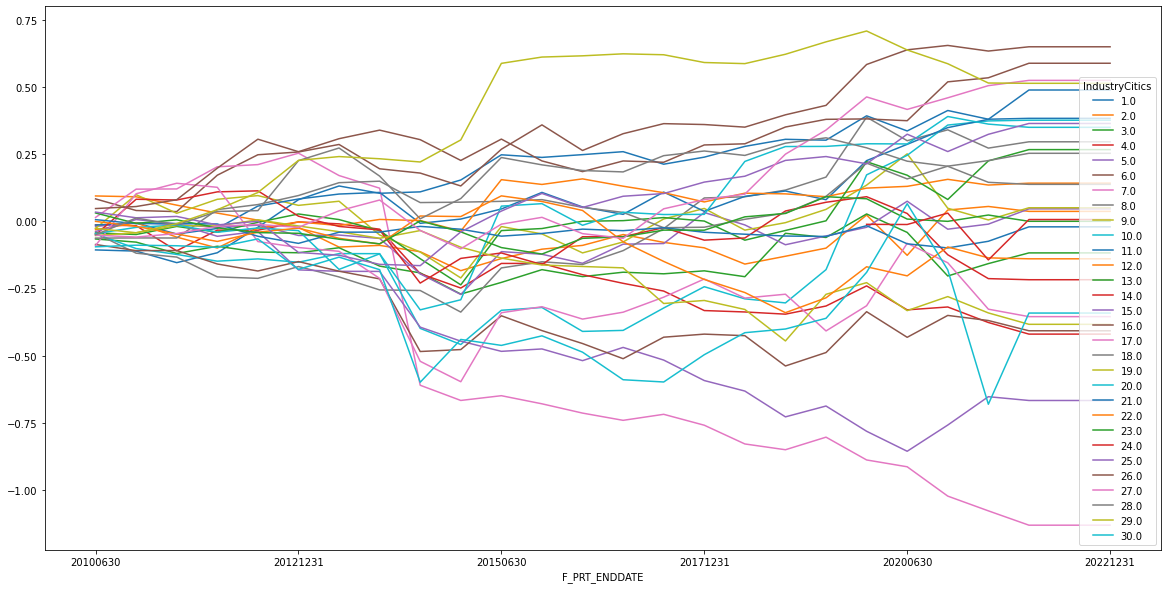

In [44]:
df_portf = df_portf.merge(fut_ret,how='left',on=['F_PRT_ENDDATE','STOCK_CODE'])
df_portf = df_portf.merge(ind_ret,how='left',on=['F_PRT_ENDDATE','IndustryCitics'])
df_portf['ALPHA'] = df_portf.FUT_RET - df_portf.IND_FUT_RET
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().cumsum().fillna(method='ffill').plot(figsize=(20,10))

In [45]:
(2*df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().mean()).sort_values()

IndustryCitics
7.0    -0.094311
15.0   -0.055594
4.0    -0.034985
16.0   -0.033949
19.0   -0.031944
17.0   -0.029558
30.0   -0.028446
14.0   -0.018097
22.0   -0.011602
3.0    -0.009768
21.0   -0.001678
23.0    0.000043
24.0    0.002851
2.0     0.003124
5.0     0.003904
9.0     0.004250
28.0    0.011516
12.0    0.011884
18.0    0.021157
13.0    0.022301
8.0     0.024728
20.0    0.029223
25.0    0.030417
10.0    0.031431
1.0     0.032011
11.0    0.040811
29.0    0.042888
27.0    0.043797
26.0    0.049116
6.0     0.054228
dtype: float64

##### 逐行业逐年统计

In [46]:
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().T.dropna(how='all',axis=1).style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, align='zero')

F_PRT_ENDDATE,20100630,20101231,20110630,20111231,20120630,20121231,20130630,20131231,20140630,20141231,20150630,20151231,20160630,20161231,20170630,20171231,20180630,20181231,20190630,20191231,20200630,20201231,20210630,20211231
IndustryCitics,,,,,,,,,,,,,,,,,,,,,,,,
1.0,-0.106134,-0.004407,-0.043013,0.036894,0.094985,0.102676,0.051111,-0.027217,0.005297,0.044231,0.093889,-0.009717,0.010323,0.011015,-0.046677,0.026318,0.040078,0.026351,-0.003249,0.090778,-0.056453,0.076274,-0.032531,0.003313
2.0,0.094919,-0.003067,-0.031164,-0.029587,-0.026294,-0.027028,-0.073328,0.006321,-0.023576,-0.070603,0.045024,0.035056,0.014062,0.040444,-0.029250,-0.020256,-0.060515,0.029167,0.030265,0.123176,-0.150019,0.168801,0.013271,-0.018336
3.0,-0.065329,-0.011731,-0.042381,0.027036,-0.021716,-0.002610,0.018668,-0.068348,-0.025254,-0.079012,0.043548,0.047511,-0.025971,0.016419,-0.005952,0.011084,-0.021842,0.161657,-0.015527,0.087656,-0.068779,-0.162358,0.046117,0.039899
4.0,-0.013027,-0.002850,-0.093614,0.077097,-0.000354,0.030928,-0.007180,-0.019906,-0.165664,-0.053611,0.091655,0.000285,-0.042148,-0.032166,-0.028878,-0.072629,-0.005248,-0.008153,0.030336,0.074957,-0.089235,0.010670,-0.057827,-0.043253
5.0,-0.018551,0.013957,-0.007247,-0.009868,0.007859,-0.038441,0.001582,-0.012596,-0.132083,-0.076704,0.159595,-0.009791,-0.033533,0.071169,0.002243,0.115645,-0.046306,-0.073773,0.032649,0.032427,0.097010,-0.104108,0.018816,0.056891
6.0,0.084056,-0.043288,-0.004100,0.135587,0.076225,0.010266,0.028085,-0.090669,-0.015952,-0.048005,0.136819,0.090760,-0.095439,0.062540,0.037483,-0.003308,-0.009700,0.045919,0.035186,0.152308,0.054653,0.016374,-0.020963,0.015898
7.0,0.014930,0.105332,0.000809,0.082451,0.008220,0.042605,-0.083358,-0.047068,-0.734286,-0.056597,0.017675,-0.030224,-0.034583,-0.026961,0.022433,-0.040644,-0.069807,-0.021549,0.046857,-0.084918,-0.025440,-0.109296,-0.054898,-0.053415
8.0,-0.044167,-0.074109,-0.014518,-0.073802,-0.005467,0.044001,-0.038736,-0.048286,-0.002244,-0.080436,0.164560,0.022874,-0.010186,0.051725,0.082067,0.114228,0.004359,0.024938,0.048416,0.223310,-0.087711,0.040471,-0.068061,0.023506
9.0,-0.026129,0.125881,-0.069324,0.052095,0.013715,-0.036350,0.015410,-0.125708,-0.063639,-0.096461,0.191489,-0.027364,-0.070841,0.040788,0.085637,0.039244,-0.080815,0.027808,0.049498,0.090361,0.116532,-0.202668,-0.043619,0.045456


##### 与行业指数估值相关性

In [47]:
ind_portf_perform = 2*df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().pipe(lambda x:x.loc[:,x.columns!=24])
### 行业基金经理全持仓组合与行业指数估值（PB）的相关性
val_col = 'PB_LF'
index_val_st = (index_val[val_col]).reindex(index=ind_portf_perform.index,columns=ind_portf_perform.columns)
index_val_st = index_val_st.apply(lambda x:(x-x.expanding().mean())/x.expanding().std(),axis=0)
dd = pd.concat([ind_portf_perform.stack().to_frame('RET'),index_val_st.stack().to_frame('VAL')],axis=1).dropna()
dd.groupby(['IndustryCitics']).apply(lambda x:x.RET.corr(x.VAL)).sort_values()

IndustryCitics
23.0   -0.316642
18.0   -0.278658
21.0   -0.176559
27.0   -0.129392
3.0    -0.098588
30.0   -0.035778
6.0    -0.027521
26.0   -0.023331
28.0   -0.016328
10.0    0.063496
2.0     0.078492
1.0     0.085633
19.0    0.107674
9.0     0.167849
11.0    0.171831
4.0     0.181798
13.0    0.201104
7.0     0.241808
14.0    0.245188
8.0     0.245962
22.0    0.278056
12.0    0.354334
15.0    0.363545
29.0    0.380591
17.0    0.407071
5.0     0.429771
20.0    0.434209
16.0    0.438587
25.0    0.510261
dtype: float64

In [48]:
### 行业基金经理全持仓组合与行业指数估值（PE）的相关性
val_col = 'PE_TTM'
index_val_st = (index_val[val_col]).reindex(index=ind_portf_perform.index,columns=ind_portf_perform.columns)
index_val_st = index_val_st.apply(lambda x:(x-x.expanding().mean())/x.expanding().std(),axis=0)
dd = pd.concat([ind_portf_perform.stack().to_frame('RET'),index_val_st.stack().to_frame('VAL')],axis=1).dropna()
dd.groupby(['IndustryCitics']).apply(lambda x:x.RET.corr(x.VAL)).sort_values()

IndustryCitics
18.0   -0.341077
23.0   -0.261699
3.0    -0.232151
28.0   -0.179555
14.0   -0.107155
26.0   -0.097394
21.0   -0.088531
11.0   -0.048478
10.0   -0.032079
6.0    -0.012481
19.0   -0.007397
9.0     0.021813
4.0     0.054351
29.0    0.091534
1.0     0.119730
5.0     0.137698
8.0     0.171016
22.0    0.173141
20.0    0.198414
30.0    0.202668
25.0    0.218966
2.0     0.231433
13.0    0.265790
7.0     0.268177
15.0    0.301512
27.0    0.322785
12.0    0.350841
16.0    0.456517
17.0    0.475998
dtype: float64

#### 冷门股

同期只有1个基金经理配置的个股视为冷门股

In [49]:
### 选取同期只有1个基金经理配置的个股视为冷门股
df_portf = portf[portf.total<=1]
df_portf = df_portf.reset_index()
df_portf = df_portf.drop_duplicates(subset=['F_PRT_ENDDATE','IndustryCitics','STOCK_CODE'],keep='last')

##### 中报公布的全持仓行业等权组合，从中报未公布到下一年报公布之间的5个区间，相对行业指数的超额表现

In [50]:
mat_close = pd.read_pickle('mat_close.pkl')
ind_close = pd.read_pickle('ind_close.pkl')
df_portf1 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('0630')],mat_close,ind_close)
alpha_stats1 = pd.concat([(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
alpha_stats1.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,3.15%,2.16%,-0.75%,-1.92%,0.54%
2.0,-1.15%,-0.24%,2.05%,-2.49%,3.31%
3.0,0.88%,0.45%,1.33%,-1.09%,0.61%
4.0,0.41%,1.20%,0.38%,0.97%,2.03%
5.0,0.86%,2.95%,0.10%,-0.32%,-0.39%
6.0,1.09%,0.54%,1.13%,0.46%,-0.15%
7.0,-0.25%,1.39%,0.82%,-0.55%,1.93%
8.0,0.55%,1.58%,1.52%,3.66%,1.97%
9.0,2.69%,0.59%,0.23%,1.93%,-0.64%


##### 年报的全持仓行业等权组合，从年报未公布到下一中报公布之间的5个区间，相对行业指数的超额表现

In [51]:
df_portf2 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('1231')],mat_close,ind_close)
alpha_stats2 = pd.concat([(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
alpha_stats2.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,-1.58%,3.89%,-0.59%,2.36%,1.94%
2.0,0.09%,0.80%,0.29%,2.17%,2.04%
3.0,0.16%,0.77%,-1.02%,5.80%,0.17%
4.0,-1.34%,1.59%,-0.32%,1.83%,0.58%
5.0,2.81%,0.09%,-1.52%,3.01%,3.78%
6.0,-0.55%,-0.37%,-0.34%,1.68%,0.61%
7.0,1.04%,0.26%,0.22%,2.71%,1.72%
8.0,0.29%,5.40%,0.61%,-0.00%,1.88%
9.0,0.30%,0.42%,-1.84%,5.41%,0.77%


##### 逐行业统计

<AxesSubplot:xlabel='F_PRT_ENDDATE'>

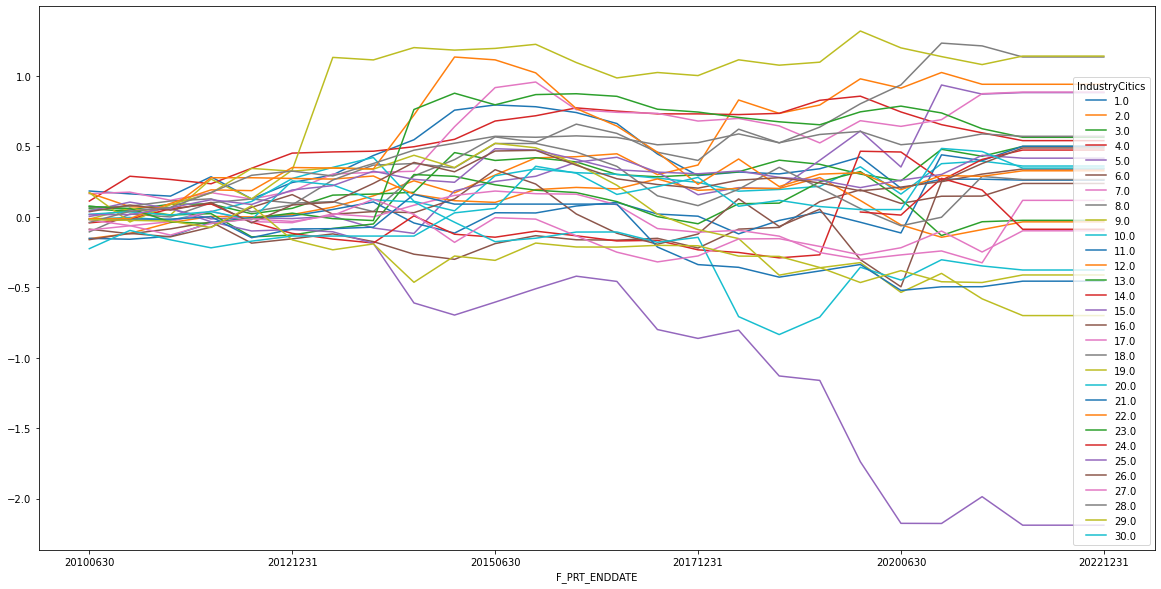

In [52]:
df_portf = df_portf.merge(fut_ret,how='left',on=['F_PRT_ENDDATE','STOCK_CODE'])
df_portf = df_portf.merge(ind_ret,how='left',on=['F_PRT_ENDDATE','IndustryCitics'])
df_portf['ALPHA'] = df_portf.FUT_RET - df_portf.IND_FUT_RET
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().cumsum().fillna(method='ffill').plot(figsize=(20,10))

In [53]:
(2*df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().mean()).sort_values()

IndustryCitics
15.0   -0.182423
19.0   -0.058424
21.0   -0.050765
24.0   -0.035354
29.0   -0.034405
20.0   -0.031472
27.0   -0.008281
12.0   -0.003125
13.0   -0.002081
17.0    0.009729
6.0     0.019724
18.0    0.022052
1.0     0.022633
22.0    0.027221
16.0    0.028263
10.0    0.030041
30.0    0.034567
25.0    0.034691
14.0    0.039488
26.0    0.040723
3.0     0.041625
11.0    0.041748
4.0     0.045063
23.0    0.047016
28.0    0.047631
5.0     0.073480
7.0     0.073787
2.0     0.081810
8.0     0.094540
9.0     0.095080
dtype: float64

##### 逐行业逐年统计

In [54]:
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().T.dropna(how='all',axis=1).style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, align='zero')

F_PRT_ENDDATE,20100630,20101231,20110630,20111231,20120630,20121231,20130630,20131231,20140630,20141231,20150630,20151231,20160630,20161231,20170630,20171231,20180630,20181231,20190630,20191231,20200630,20201231,20210630,20211231
IndustryCitics,,,,,,,,,,,,,,,,,,,,,,,,
1.0,0.183160,-0.020304,-0.016124,0.137671,-0.157603,0.116627,0.054260,0.137413,0.111786,0.210110,0.037142,-0.012799,-0.041247,-0.077861,-0.216260,-0.153374,0.025211,-0.013131,0.036456,0.083421,-0.221862,0.064358,nan,-0.006770
2.0,-0.154948,0.037260,0.076944,0.043495,-0.003525,0.016846,0.052628,0.080124,0.106731,-0.085211,0.125933,0.121983,0.008467,0.020568,-0.147680,0.068070,0.461481,-0.094813,0.059161,0.185877,-0.066056,0.111017,-0.083539,nan
3.0,0.075633,-0.025064,0.038580,0.001958,-0.069489,0.038556,0.093641,0.007489,0.012832,0.281693,-0.055798,0.019280,-0.029664,-0.089438,-0.016177,0.014595,0.021240,0.082153,-0.029202,-0.069581,-0.047724,0.223791,-0.049595,0.069797
4.0,0.111562,0.176408,-0.023069,-0.030456,0.110213,0.107488,0.008400,0.005040,0.031803,0.052615,0.129949,0.037326,0.055973,-0.022889,-0.019720,-0.000050,-0.004906,0.008646,0.092780,0.029250,-0.112030,-0.090249,-0.057827,-0.055503
5.0,0.002507,0.047027,0.007497,-0.071805,0.007872,-0.005627,0.016466,-0.083160,-0.038523,0.302056,0.066477,0.036861,0.099998,0.035045,-0.106172,-0.159857,0.050377,-0.007706,0.201626,0.208417,-0.255750,0.582036,-0.064696,0.010794
6.0,-0.087778,-0.032640,0.034679,0.049500,-0.150743,0.030483,0.035141,-0.054761,-0.089458,-0.036241,0.111607,0.056233,-0.029025,-0.002837,0.013115,-0.068685,0.134017,0.012154,0.183264,0.083685,-0.096664,0.050985,0.001049,0.089611
7.0,0.164189,0.010979,-0.057940,0.054413,-0.045861,0.056166,0.121789,0.011696,0.007870,0.316279,0.277622,0.039632,-0.196553,-0.018575,-0.007380,-0.054626,0.018536,-0.053043,-0.120593,0.157646,-0.040227,0.047729,0.184343,0.011351
8.0,-0.107096,0.126818,-0.020783,0.101163,0.026415,-0.029442,0.010695,-0.070808,0.253035,0.115872,0.161355,-0.038388,0.128937,-0.065650,-0.133766,-0.058148,0.221895,-0.097186,0.111909,0.165468,0.134276,0.296453,-0.019778,-0.078772
9.0,-0.016986,0.077936,-0.047298,0.253981,-0.140494,0.204416,0.800040,-0.017873,0.087430,-0.017831,0.012155,0.028950,-0.129368,-0.109356,0.038725,-0.021847,0.111858,-0.038100,0.021353,0.221266,-0.119722,-0.061913,-0.056701,0.060339


##### 与行业指数估值相关性

In [55]:
ind_portf_perform = 2*df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().pipe(lambda x:x.loc[:,x.columns!=24])
### 行业基金经理全持仓组合与行业指数估值（PB）的相关性
val_col = 'PB_LF'
index_val_st = (index_val[val_col]).reindex(index=ind_portf_perform.index,columns=ind_portf_perform.columns)
index_val_st = index_val_st.apply(lambda x:(x-x.expanding().mean())/x.expanding().std(),axis=0)
dd = pd.concat([ind_portf_perform.stack().to_frame('RET'),index_val_st.stack().to_frame('VAL')],axis=1).dropna()
dd.groupby(['IndustryCitics']).apply(lambda x:x.RET.corr(x.VAL)).sort_values()

IndustryCitics
9.0    -0.317018
21.0   -0.280865
27.0   -0.215698
13.0   -0.197918
19.0   -0.163727
14.0   -0.125102
23.0   -0.104922
12.0   -0.059053
3.0    -0.025571
17.0   -0.003118
2.0     0.005298
28.0    0.062940
8.0     0.079041
5.0     0.083527
20.0    0.105926
1.0     0.130571
15.0    0.132730
29.0    0.135307
6.0     0.146330
10.0    0.174258
26.0    0.238863
22.0    0.240677
25.0    0.247049
11.0    0.258830
30.0    0.278975
18.0    0.282285
16.0    0.300013
7.0     0.353508
4.0     0.433425
dtype: float64

In [56]:
### 行业基金经理全持仓组合与行业指数估值（PE）的相关性
val_col = 'PE_TTM'
index_val_st = (index_val[val_col]).reindex(index=ind_portf_perform.index,columns=ind_portf_perform.columns)
index_val_st = index_val_st.apply(lambda x:(x-x.expanding().mean())/x.expanding().std(),axis=0)
dd = pd.concat([ind_portf_perform.stack().to_frame('RET'),index_val_st.stack().to_frame('VAL')],axis=1).dropna()
dd.groupby(['IndustryCitics']).apply(lambda x:x.RET.corr(x.VAL)).sort_values()

IndustryCitics
13.0   -0.434628
21.0   -0.341277
19.0   -0.242012
28.0   -0.201766
1.0    -0.201663
14.0   -0.186787
8.0    -0.125489
6.0    -0.121348
23.0   -0.108255
9.0    -0.096023
20.0   -0.048403
17.0   -0.030477
12.0   -0.015371
27.0    0.008297
3.0     0.020872
26.0    0.028895
2.0     0.032775
15.0    0.042920
10.0    0.047170
5.0     0.067874
18.0    0.074951
4.0     0.101260
29.0    0.130232
11.0    0.152584
22.0    0.287859
16.0    0.291493
7.0     0.312171
30.0    0.346136
25.0    0.408567
dtype: float64

### 根据季度重仓股表现选择年报/半年报基金经理的全持仓

In [57]:
### 取年报/半年报的上一季报至当期年报/半年报区间重仓股有超额的基金经理，记录其年报/半年报的全持仓
portf_list = []
for ind,sub in ind_manager.groupby('IndustryCitics'):
    if len(sub) < 10:
        continue
    print(ind,len(sub))
    sub = sub.merge(stocks_eval[stocks_eval.IndustryCitics==ind],how='left',on=['F_INFO_FUNDMANAGER_ID','F_PRT_ENDDATE','IndustryCitics'])
    hld = manager_holding_ind[manager_holding_ind.IndustryCitics==ind]
    hld = hld.groupby(['F_PRT_ENDDATE','F_MANAGER'])['S_INFO_STOCKWINDCODE'].apply(list).to_frame()
    portf = sub.merge(hld,how='left',left_on=['F_PRT_ENDDATE','F_INFO_FUNDMANAGER_ID'],right_index=True)
    portf = portf[portf.Alpha>0]
    portf = portf.set_index(['F_INFO_FUNDMANAGER_ID','F_PRT_ENDDATE','IndustryCitics'])['S_INFO_STOCKWINDCODE'].explode()
    portf_list.append(portf)

1.0 260
2.0 267
3.0 329
4.0 260
5.0 260
6.0 284
7.0 260
8.0 260
9.0 260
10.0 265
11.0 604
12.0 405
13.0 268
14.0 260
15.0 260
16.0 260
17.0 261
18.0 1166
19.0 906
20.0 287
21.0 368
22.0 294
23.0 279
24.0 63
25.0 260
26.0 748
27.0 260
28.0 469
29.0 264
30.0 261


In [58]:
portf = pd.concat(portf_list,axis=0)
portf = portf.reset_index(level='F_INFO_FUNDMANAGER_ID',drop=True)
portf = portf.to_frame('STOCK_CODE')
portf['num'] = 1
portf = portf.set_index(['STOCK_CODE'],append=True)
portf['total'] = portf.groupby(['F_PRT_ENDDATE','IndustryCitics','STOCK_CODE']).num.sum()

In [59]:
df_portf = portf.reset_index()
df_portf = df_portf.drop_duplicates(subset=['F_PRT_ENDDATE','IndustryCitics','STOCK_CODE'],keep='last')

##### 中报公布的全持仓行业等权组合，从中报未公布到下一年报公布之间的5个区间，相对行业指数的超额表现

In [60]:
### 计算全持仓从年报/半年报日期（非公告日期）至下一期半年报/年报的公告日期之间，各个阶段的行业持股超额
mat_close = pd.read_pickle('mat_close.pkl')
ind_close = pd.read_pickle('ind_close.pkl')
df_portf1 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('0630')],mat_close,ind_close)
format_dict = {'ALPHA1': '{:.2%}','ALPHA2': '{:.2%}','ALPHA3': '{:.2%}','ALPHA4': '{:.2%}','ALPHA5': '{:.2%}'}
#### 中报为起点
alpha_stats1 = pd.concat([(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
alpha_stats1.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,0.74%,0.01%,-0.16%,1.38%,1.16%
2.0,1.48%,-0.61%,-0.74%,0.23%,0.34%
3.0,0.80%,0.13%,-0.84%,0.66%,-0.10%
4.0,0.30%,0.36%,-0.52%,-1.63%,0.74%
5.0,1.85%,2.23%,-0.86%,3.07%,-2.04%
6.0,-0.10%,0.14%,0.21%,1.69%,-0.58%
7.0,-1.41%,1.95%,-2.07%,-3.44%,1.07%
8.0,0.66%,0.58%,0.38%,1.37%,-1.05%
9.0,-1.12%,-0.06%,-2.30%,0.09%,2.61%


##### 年报的全持仓行业等权组合，从年报未公布到下一中报公布之间的5个区间，相对行业指数的超额表现

In [61]:
#### 年报为起点
df_portf2 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('1231')],mat_close,ind_close)
alpha_stats2 = pd.concat([(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
alpha_stats2.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,0.64%,-0.93%,-0.55%,4.71%,-0.73%
2.0,1.50%,0.80%,-0.57%,-0.37%,0.98%
3.0,-0.42%,-0.61%,-0.23%,1.19%,0.02%
4.0,-0.86%,-0.81%,-0.74%,0.51%,0.50%
5.0,0.84%,-3.65%,-2.89%,1.40%,0.61%
6.0,0.52%,0.47%,0.10%,2.03%,-0.19%
7.0,0.06%,2.65%,-2.49%,3.10%,0.44%
8.0,1.49%,0.56%,0.87%,1.29%,0.03%
9.0,0.63%,1.83%,-0.00%,-0.02%,2.54%


##### 逐行业统计

<AxesSubplot:xlabel='F_PRT_ENDDATE'>

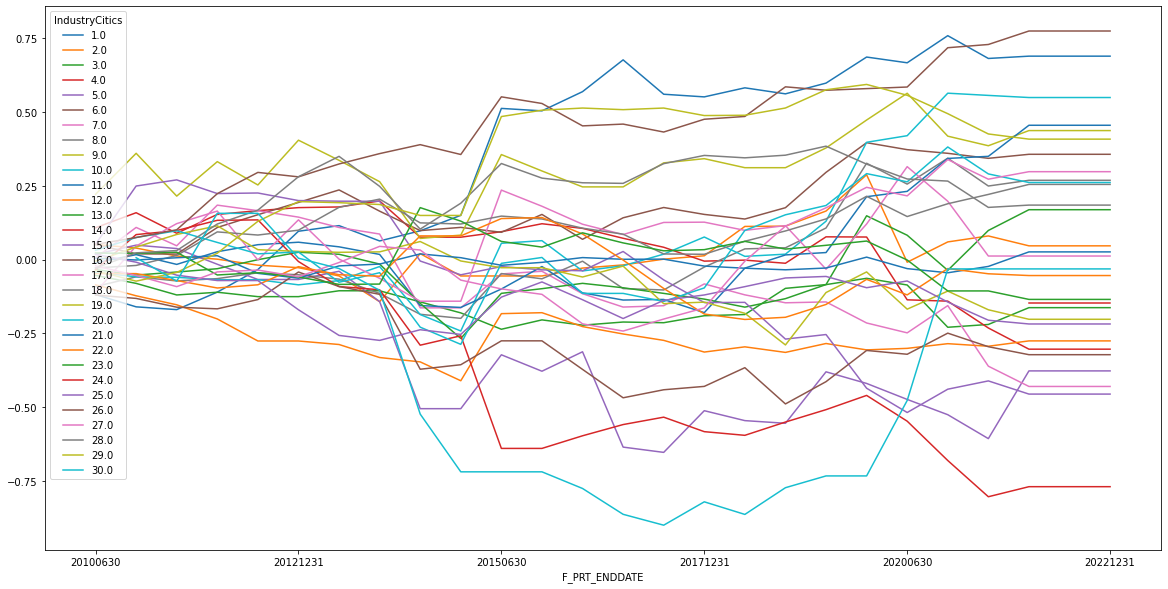

In [62]:
df_portf = df_portf.merge(fut_ret,how='left',on=['F_PRT_ENDDATE','STOCK_CODE'])
df_portf = df_portf.merge(ind_ret,how='left',on=['F_PRT_ENDDATE','IndustryCitics'])
df_portf['ALPHA'] = df_portf.FUT_RET - df_portf.IND_FUT_RET
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().cumsum().fillna(method='ffill').plot(figsize=(20,10))

In [63]:
### 有超额的行业基金经理，等权全持仓组合相对中信行业指数的超额表现
(2*df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().mean()).sort_values()

IndustryCitics
24.0   -0.292604
14.0   -0.066949
15.0   -0.038007
7.0    -0.037411
5.0    -0.034319
16.0   -0.028049
4.0    -0.026423
12.0   -0.023984
25.0   -0.018998
19.0   -0.017612
3.0    -0.014833
23.0   -0.011757
22.0   -0.004939
30.0   -0.003749
17.0    0.001075
21.0    0.002152
2.0     0.004213
13.0    0.014068
28.0    0.015369
18.0    0.021212
8.0     0.022375
20.0    0.022698
27.0    0.024806
6.0     0.029716
29.0    0.035477
11.0    0.037916
9.0     0.039725
10.0    0.047741
1.0     0.057434
26.0    0.064539
dtype: float64

##### 逐行业逐年统计

In [64]:
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().T.dropna(how='all',axis=1).style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, align='zero')

F_PRT_ENDDATE,20100630,20101231,20110630,20111231,20120630,20121231,20130630,20131231,20140630,20141231,20150630,20151231,20160630,20161231,20170630,20171231,20180630,20181231,20190630,20191231,20200630,20201231,20210630,20211231
IndustryCitics,,,,,,,,,,,,,,,,,,,,,,,,
1.0,-0.118685,-0.041723,-0.009417,0.059289,0.076475,0.129860,0.019023,-0.051918,0.034339,0.052514,0.362372,-0.008284,0.065056,0.107761,-0.116509,-0.008964,0.030687,-0.020399,0.036393,0.088325,-0.019467,0.091933,-0.077259,0.007811
2.0,0.051106,-0.012343,-0.026914,-0.010691,-0.020305,-0.008500,-0.027984,-0.087342,0.162925,-0.075736,nan,nan,0.026748,0.010699,0.019502,0.011501,0.099467,0.000923,0.051252,0.122978,-0.296429,0.068771,0.020268,-0.033550
3.0,-0.053857,-0.027013,-0.039268,0.009240,-0.014923,nan,0.019894,nan,-0.037765,-0.037227,-0.055433,0.031729,-0.017900,0.010651,-0.002319,0.023685,0.004112,0.088655,0.012709,0.021321,-0.022663,-0.143240,0.009494,0.056952
4.0,0.107669,0.050928,-0.069579,0.063800,0.012748,0.010318,0.002251,0.020230,-0.122703,nan,0.018604,0.026980,-0.015693,-0.033559,-0.030464,-0.047008,0.003413,-0.010629,0.089544,-0.000628,-0.212816,-0.004490,-0.090983,-0.071799
5.0,0.017701,0.030988,-0.011545,-0.053216,-0.051598,nan,0.027815,-0.102854,-0.362831,nan,0.182635,-0.055661,0.065850,-0.323060,-0.017892,0.141300,-0.033657,-0.008996,0.174395,-0.039379,-0.054167,-0.051787,-0.081072,0.229525
6.0,0.050632,-0.031507,-0.000682,0.090133,0.043288,0.041567,0.042430,-0.071997,-0.065888,0.010952,-0.016691,0.060577,-0.084354,0.072971,0.034861,-0.023432,-0.015632,0.038380,0.119828,0.100526,-0.023637,-0.012387,-0.016985,0.013644
7.0,0.005645,0.103107,-0.062182,0.137735,-0.018820,-0.021832,-0.035088,-0.022237,-0.250095,nan,0.114869,0.009053,-0.076038,-0.045247,0.004561,0.073858,-0.037073,-0.026906,0.002994,-0.071357,-0.033507,0.092351,-0.205323,-0.068693
8.0,-0.091713,0.033035,-0.013915,0.007848,0.019796,-0.006777,-0.014854,-0.048279,-0.070794,-0.013759,0.151834,-0.017826,0.059693,-0.092757,-0.004740,0.077640,0.061605,0.003675,0.067091,0.219454,-0.070719,0.087874,-0.094332,0.019417
9.0,0.220912,0.139058,-0.145072,0.116781,-0.079053,0.151809,-0.068241,-0.072341,-0.192414,0.011320,0.272962,-0.055645,-0.053937,nan,0.081373,0.014252,-0.030552,nan,0.066925,0.094562,0.090771,-0.145403,-0.032487,0.051392


#### 热门股

In [65]:
### 选取同期被超过1个基金经理配置的个股视为热门股
df_portf = portf[portf.total>1]
df_portf = df_portf.reset_index()
df_portf = df_portf.drop_duplicates(subset=['F_PRT_ENDDATE','IndustryCitics','STOCK_CODE'],keep='last')

##### 中报公布的全持仓行业等权组合，从中报未公布到下一年报公布之间的5个区间，相对行业指数的超额表现

In [66]:
mat_close = pd.read_pickle('mat_close.pkl')
ind_close = pd.read_pickle('ind_close.pkl')
df_portf1 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('0630')],mat_close,ind_close)
alpha_stats1 = pd.concat([(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
df_portf2 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('1231')],mat_close,ind_close)
alpha_stats1.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,1.07%,-0.27%,0.79%,4.87%,2.15%
2.0,2.98%,-1.40%,-2.09%,-3.49%,-1.23%
3.0,1.25%,-0.28%,-1.20%,0.97%,-0.38%
4.0,0.03%,-0.18%,-2.34%,-3.05%,-0.10%
5.0,1.09%,1.52%,-2.21%,5.92%,1.81%
6.0,-0.61%,0.87%,-2.99%,1.87%,-0.78%
7.0,0.63%,1.37%,-3.67%,-4.58%,0.71%
8.0,0.22%,0.67%,-0.40%,3.73%,-1.29%
9.0,-2.10%,-0.71%,-2.63%,-1.10%,2.54%


##### 年报的全持仓行业等权组合，从年报未公布到下一中报公布之间的5个区间，相对行业指数的超额表现

In [67]:
alpha_stats2 = pd.concat([(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
alpha_stats2.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,-1.63%,-0.23%,-0.41%,3.32%,-0.90%
2.0,1.64%,0.38%,-1.29%,-1.07%,1.46%
3.0,-0.12%,-3.47%,0.07%,0.85%,-0.16%
4.0,-0.72%,-2.71%,-2.01%,0.60%,0.00%
5.0,3.58%,-2.51%,-2.28%,-3.11%,-0.36%
6.0,0.49%,-0.25%,1.01%,1.99%,0.02%
7.0,-0.02%,3.47%,-3.13%,2.59%,1.03%
8.0,2.72%,-1.28%,-0.02%,2.99%,-0.32%
9.0,-0.54%,3.47%,1.06%,-1.57%,3.04%


##### 逐行业统计

<AxesSubplot:xlabel='F_PRT_ENDDATE'>

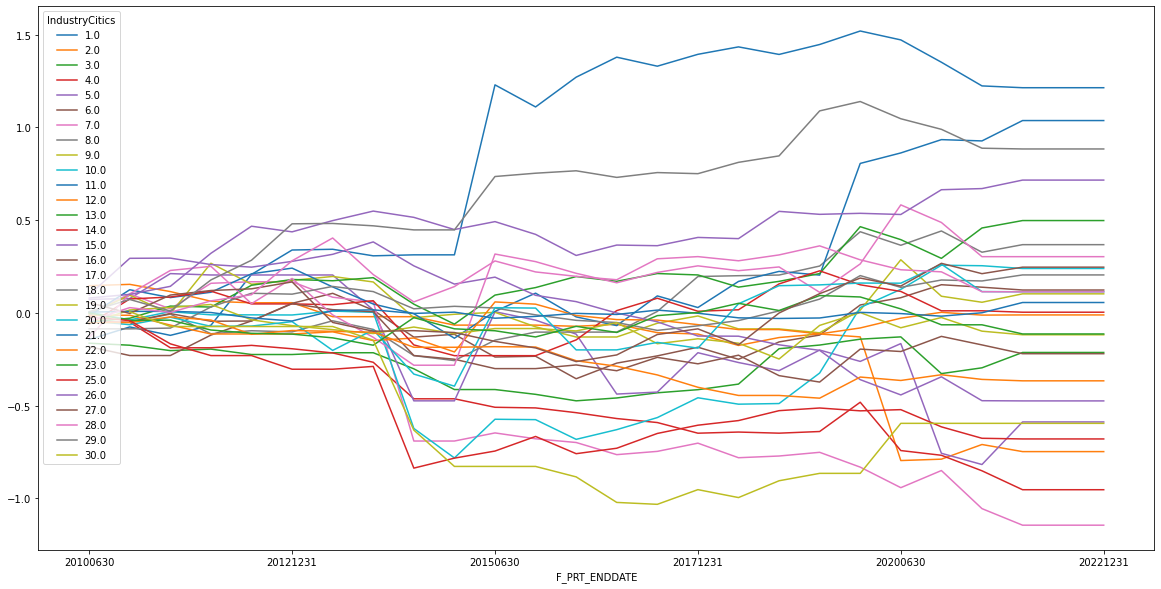

In [68]:
df_portf = df_portf.merge(fut_ret,how='left',on=['F_PRT_ENDDATE','STOCK_CODE'])
df_portf = df_portf.merge(ind_ret,how='left',on=['F_PRT_ENDDATE','IndustryCitics'])
df_portf['ALPHA'] = df_portf.FUT_RET - df_portf.IND_FUT_RET
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().cumsum().fillna(method='ffill').plot(figsize=(20,10))

In [69]:
(2*df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().mean()).sort_values()

IndustryCitics
7.0    -0.104027
30.0   -0.091593
4.0    -0.086647
2.0    -0.074769
25.0   -0.061769
5.0    -0.058773
15.0   -0.039529
22.0   -0.034872
3.0    -0.020313
16.0   -0.019996
19.0   -0.010251
23.0   -0.009865
12.0   -0.001093
14.0    0.000373
21.0    0.004669
9.0     0.009345
28.0    0.009460
20.0    0.009900
6.0     0.010282
18.0    0.017801
27.0    0.020546
10.0    0.020819
17.0    0.027554
8.0     0.033441
13.0    0.041483
26.0    0.059662
29.0    0.076843
11.0    0.086403
1.0     0.105550
dtype: float64

##### 逐行业逐年统计

In [70]:
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().T.dropna(how='all',axis=1).style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, align='zero')

F_PRT_ENDDATE,20100630,20101231,20110630,20111231,20120630,20121231,20130630,20131231,20140630,20141231,20150630,20151231,20160630,20161231,20170630,20171231,20180630,20181231,20190630,20191231,20200630,20201231,20210630,20211231
IndustryCitics,,,,,,,,,,,,,,,,,,,,,,,,
1.0,-0.144108,0.068448,-0.045345,0.054415,0.273919,0.131659,0.003989,-0.035307,0.005297,nan,0.916230,-0.118927,0.160402,0.107761,-0.048549,0.063983,0.040078,-0.040696,0.053541,0.072761,-0.048005,-0.120338,-0.127622,-0.009762
2.0,0.146681,0.007198,-0.038906,-0.052170,-0.008352,0.000531,-0.075432,nan,nan,-0.045373,nan,nan,-0.006434,0.010699,-0.044964,-0.007392,-0.061428,0.042509,0.019219,-0.015765,-0.666473,0.007427,0.079037,-0.038299
3.0,-0.163383,-0.010842,-0.029063,0.008053,-0.029075,nan,0.009583,nan,-0.086733,-0.111640,nan,-0.025894,-0.034952,0.015449,0.027813,0.016843,0.030077,0.190815,0.019617,0.031733,0.012305,-0.197921,0.031204,0.082720
4.0,-0.047591,-0.002850,-0.137606,nan,0.013096,-0.018376,-0.022458,-0.050387,-0.196889,nan,-0.045670,-0.003429,-0.025670,-0.031615,-0.021580,-0.057413,0.006153,-0.006004,0.008914,0.157859,-0.260510,-0.025443,-0.083646,-0.102005
5.0,0.072857,0.004691,0.134260,-0.007368,nan,nan,nan,-0.188657,-0.489859,nan,0.480384,-0.045350,-0.075401,-0.323060,0.010695,0.212174,-0.052847,-0.043532,0.110828,-0.061346,0.096145,-0.591342,-0.060531,0.229525
6.0,-0.181925,-0.047873,0.000006,0.110179,0.076583,0.094591,0.053974,-0.090669,-0.145361,0.015025,-0.122423,0.004194,-0.121200,0.084204,0.039082,0.046701,-0.065212,0.093670,0.036961,0.162262,0.039309,0.069869,-0.013439,-0.015129
7.0,-0.003520,0.105332,-0.079924,0.137779,0.008220,nan,-0.083358,-0.025024,-0.750140,nan,0.043674,-0.031664,-0.019975,-0.065469,0.017618,0.044340,-0.078545,0.009215,0.019974,-0.079890,-0.110722,0.092351,-0.205323,-0.089246
8.0,nan,-0.048990,0.042604,-0.106134,0.016447,-0.006344,0.059877,-0.046472,-0.141352,-0.026696,0.110199,0.043286,0.000070,nan,0.111419,0.188194,0.004359,0.003675,0.048416,0.184975,-0.072962,0.077030,-0.114468,0.040714
9.0,-0.005799,0.101014,-0.099754,0.272098,-0.112957,0.020744,0.021099,-0.029745,-0.192414,0.018380,0.010490,-0.078304,-0.054712,nan,0.074129,0.039244,-0.069863,nan,-0.020955,0.121732,0.271885,-0.196483,-0.032487,0.045456


#### 冷门股

In [71]:
### 选取同期只有1个基金经理配置的个股视为冷门股
df_portf = portf[portf.total<=1]
df_portf = df_portf.reset_index()
df_portf = df_portf.drop_duplicates(subset=['F_PRT_ENDDATE','IndustryCitics','STOCK_CODE'],keep='last')

##### 中报的全持仓行业等权组合，从中报未公布到下一年报公布之间的5个区间，相对行业指数的超额表现

In [72]:
mat_close = pd.read_pickle('mat_close.pkl')
ind_close = pd.read_pickle('ind_close.pkl')
df_portf1 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('0630')],mat_close,ind_close)
alpha_stats1 = pd.concat([(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf1.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
alpha_stats1.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,2.16%,2.56%,0.44%,0.09%,4.68%
2.0,-0.51%,-0.31%,0.87%,2.81%,4.46%
3.0,-0.21%,0.55%,-0.31%,0.35%,-0.57%
4.0,-0.26%,0.24%,1.00%,0.30%,0.29%
5.0,0.42%,2.47%,-1.21%,0.58%,-2.66%
6.0,0.31%,-0.39%,2.14%,2.63%,-1.27%
7.0,-1.05%,4.36%,-0.76%,-1.06%,2.21%
8.0,1.94%,-0.54%,0.87%,0.61%,-0.42%
9.0,-0.13%,4.85%,-1.37%,-1.13%,3.57%


##### 年报的全持仓行业等权组合，从年报未公布到下一中报公布之间的5个区间，相对行业指数的超额表现

In [73]:
df_portf2 = portf_stages(df_portf[df_portf.F_PRT_ENDDATE.str.endswith('1231')],mat_close,ind_close)
alpha_stats2 = pd.concat([(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA1.mean().unstack().mean()).to_frame('ALPHA1'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA2.mean().unstack().mean()).to_frame('ALPHA2'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA3.mean().unstack().mean()).to_frame('ALPHA3'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA4.mean().unstack().mean()).to_frame('ALPHA4'),
(df_portf2.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA5.mean().unstack().mean()).to_frame('ALPHA5')],axis=1)
alpha_stats2.style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, subset=['ALPHA1','ALPHA2','ALPHA3','ALPHA4','ALPHA5'], align='zero')

,ALPHA1,ALPHA2,ALPHA3,ALPHA4,ALPHA5
IndustryCitics,,,,,
1.0,4.35%,0.62%,-0.86%,11.06%,-0.38%
2.0,-0.21%,2.41%,1.78%,-1.08%,0.67%
3.0,-2.01%,1.50%,-0.50%,3.35%,0.42%
4.0,-0.18%,0.99%,1.65%,0.78%,0.80%
5.0,-1.53%,-4.58%,-1.49%,6.88%,0.36%
6.0,0.15%,1.39%,-1.24%,1.61%,-0.75%
7.0,0.20%,-1.26%,-1.57%,6.59%,-1.69%
8.0,0.57%,3.26%,0.07%,0.44%,2.28%
9.0,-0.07%,0.97%,-0.86%,2.49%,2.69%


##### 逐行业统计

<AxesSubplot:xlabel='F_PRT_ENDDATE'>

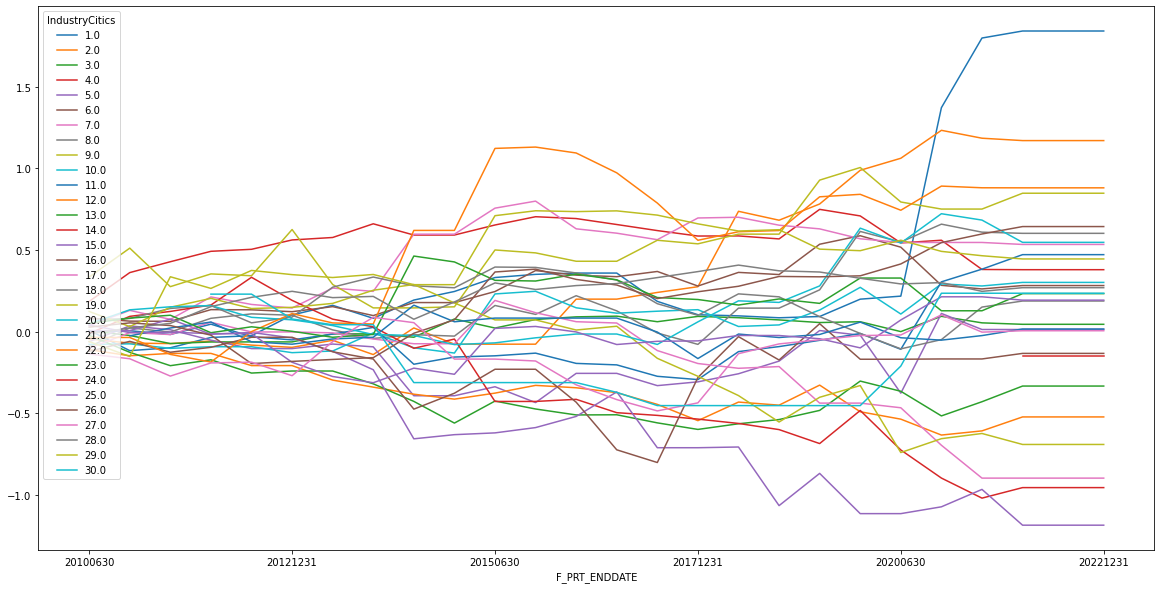

In [74]:
df_portf = df_portf.merge(fut_ret,how='left',on=['F_PRT_ENDDATE','STOCK_CODE'])
df_portf = df_portf.merge(ind_ret,how='left',on=['F_PRT_ENDDATE','IndustryCitics'])
df_portf['ALPHA'] = df_portf.FUT_RET - df_portf.IND_FUT_RET
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().cumsum().fillna(method='ffill').plot(figsize=(20,10))

In [75]:
(2*df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().mean()).sort_values()

IndustryCitics
24.0   -0.292604
15.0   -0.112780
17.0   -0.089615
14.0   -0.082976
19.0   -0.060013
12.0   -0.047422
13.0   -0.028931
16.0   -0.013282
27.0    0.000484
5.0     0.001343
21.0    0.001657
3.0     0.004112
18.0    0.015650
25.0    0.017551
23.0    0.021182
28.0    0.022445
6.0     0.023536
10.0    0.026229
4.0     0.032998
29.0    0.038714
11.0    0.039294
20.0    0.047547
7.0     0.050854
8.0     0.052345
26.0    0.053618
30.0    0.058854
22.0    0.080043
9.0     0.084744
2.0     0.111390
1.0     0.160025
dtype: float64

逐行业逐年统计

In [76]:
df_portf.groupby(['F_PRT_ENDDATE','IndustryCitics']).ALPHA.mean().unstack().T.dropna(how='all',axis=1).style.format(format_dict).bar(color=['#5fba7d','#d65f5f'], vmin=0, align='zero')

F_PRT_ENDDATE,20100630,20101231,20110630,20111231,20120630,20121231,20130630,20131231,20140630,20141231,20150630,20151231,20160630,20161231,20170630,20171231,20180630,20181231,20190630,20191231,20200630,20201231,20210630,20211231
IndustryCitics,,,,,,,,,,,,,,,,,,,,,,,,
1.0,0.008429,-0.124351,0.017528,0.063188,0.010661,0.126860,0.059114,-0.079605,0.111786,0.052514,0.085443,0.019377,0.007848,nan,-0.173142,-0.081911,-0.006876,-0.011700,0.007812,0.106113,0.018584,1.153289,0.426370,0.042958
2.0,-0.044468,-0.025371,-0.002929,0.015705,-0.025086,-0.013661,0.043189,-0.087342,0.162925,-0.099351,nan,nan,0.275615,nan,0.040990,0.035117,0.461481,-0.054526,0.099301,0.206224,0.073615,0.171012,-0.048296,-0.014556
3.0,0.005885,-0.029034,-0.049472,0.009671,0.000407,nan,0.049354,nan,-0.020626,0.111598,-0.055433,0.052308,0.016204,0.004253,-0.034038,0.032540,-0.008005,-0.013505,-0.016073,0.004834,-0.060321,0.093712,-0.040129,-0.008900
4.0,0.185299,0.176408,0.066473,0.063800,0.012254,0.057271,0.015064,0.083784,-0.068750,nan,0.061453,0.050632,-0.011258,-0.036476,-0.037127,-0.033352,0.000673,-0.018337,0.180926,-0.040250,-0.165123,0.016464,-0.179030,-0.001317
5.0,-0.061093,0.096731,-0.023696,-0.063797,-0.051598,nan,0.027815,-0.017051,-0.299317,nan,0.055028,-0.096904,0.178851,nan,-0.075065,0.023177,0.049499,0.077344,0.187108,-0.028395,-0.354790,0.487769,-0.098189,nan
6.0,0.083854,-0.019233,-0.001127,0.071519,-0.001106,-0.011457,0.030885,-0.054761,0.079811,-0.000450,0.067895,0.128236,-0.028001,-0.009404,0.031950,-0.089181,0.083527,-0.013224,0.185551,0.052020,-0.070097,-0.233451,-0.022023,0.020702
7.0,0.037721,0.092723,-0.055085,0.137336,-0.045861,-0.021832,0.121789,-0.020006,0.349960,nan,0.159365,0.042984,-0.169477,-0.026710,-0.039834,0.132895,0.004398,-0.048579,-0.022477,-0.060690,-0.022477,nan,nan,-0.012173
8.0,-0.091713,0.115061,-0.025219,0.083836,0.027166,-0.008509,-0.089584,-0.052495,0.023282,-0.008908,0.187522,-0.054493,0.114347,-0.092757,-0.135419,-0.069765,0.221895,nan,0.111909,0.357366,-0.064886,0.109561,-0.049026,-0.007203
9.0,0.334268,0.177103,-0.235706,0.077951,-0.011244,0.282875,-0.336261,-0.143335,nan,0.006612,0.347954,-0.017880,-0.051225,nan,0.128462,-0.021847,0.059301,nan,0.330568,0.077272,-0.211086,-0.043242,nan,0.096896
